In [2]:
import CandidatePairGenerator

In [3]:
%load_ext autoreload
%autoreload 2

import cPickle, os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))

from ddlite import *

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (18,6)

In [4]:
DDL = CandidatePairGenerator.doEverything()

biomarker
biomarker
MarkerIdx:
7
ROOTIdx:
[u'punct', u'amod', u'compound', u'conj', u'punct', u'conj', u'punct']


marker
biomarker
MarkerIdx:
7
ROOTIdx:
[u'auxpass', u'csubj', u'case', u'compound', u'nmod', u'cop', u'det']


biomarker
MarkerIdx:
2
ROOTIdx:
[u'cop', u'det']




biomarker
MarkerIdx:
2
ROOTIdx:
[u'cop', u'det']


biomarker
biomarker
MarkerIdx:
2
ROOTIdx:
[u'cop', u'det']


biomarker
MarkerIdx:
2
ROOTIdx:
[u'cop', u'det']


biomarker
MarkerIdx:
2
ROOTIdx:
[u'cop', u'det']


marker
marker


marker
marker
marker
MarkerIdx:
9
ROOTIdx:
[u'nsubj', u'cop', u'nsubj', u'acl:relcl', u'cc', u'conj', u'case', u'det', u'amod']


biomarker
MarkerIdx:
2
ROOTIdx:
[u'cop', u'det']


marker
MarkerIdx:
15
ROOTIdx:
[u'punct', u'nsubjpass', u'auxpass', u'ROOT', u'case', u'compound', u'nmod', u'cc', u'aux', u'cop', u'conj', u'case', u'det', u'compound', u'compound']
3




We need a blind, gold standard ground truth set to evaluate our predictions. We can add these by using the uids for the candidates we want, and align these with a value of 1 for positive or a value of -1 for negative. We'll load in a set now using `DDL.update_gt()` and set it as the holdout. We'll assign half of the holdout to a validation set for parameter tuning, and the other half to a test set.

## Building a ground truth set with MindTagger
In order to evaluate our labeling functions and learning results, we'll create a small set of ground truth labels for some candidates using [Mindtagger](http://deepdive.stanford.edu/labeling). This will highlight each candidate in the sentence in which it appears. We set the response to yes if it is a mention of gene, and no otherwise. If you aren't sure, you can abstain from labeling. In a real application, we would likely want to tag more than 20 candidates.

Now, we'll retrieve the tags and add them to our `DDLiteModel`. We can also use a previously defined Mindtagger label set, similar to how we added our gold labels (this time, we'll use indexes instead of uids). These labels are used for evaluating our labeling functions against the *development set*.

## Writing labeling functions
We'll use data programming to learn a logistic regression model which will predict the probability of a candidate entity being a true gene mention. Since our training data is not manually labeled, we'll generate many (potentially noisy) labels as a surrogate for precise, manual labels. Feature extraction and model learning are very simple in ddlite. Writing labeling functions is where the real artistry comes in. One of ddlite's goals is to enable rapid prototyping, debugging, and experimenting with labeling functions. These can be used either to create a simple standalone app, or to plug into DeepDive. Labeling functions, or LFs, are functions that take an `Candidate` object. They must return 1 (for a positive label), 0 (for abstaining), or -1 (for a negative example). For now, we'll write a few simple LFs to get started:

* The first, second, and third LFs return a positive label if the lemma "gene", "mutant", or "express" appear in a window around the mention, respectively
* The third LF returns a positive label if the dependency parent of any of the words in the mention is "mutation", and abstains otherwise
* The fourth, fifth, and sixth LF return a negative label if the mention candidate contains "DNA", "RNA", or "SNP" respectively (these are common uppercase nouns which are not genes) 

Our intuition is that the few simple LFs given above won't yield a good model. We'll see this more concretely when we evaluate the labeling functions. For now, let's leave them as is. After writing the LFs, we simply collect them and apply them to mentions. If we define more LFs later, we can apply them incrementally or overwrite all the LFs so far.

We'll use ddlite's LF assessment utilities to debug and analyze our LFs before running inference. First, we'll generate summary plots which show the following:

* Do the LFs cover the data well or do we have many candidates for which all of the LFs abstained?
* Is there overlap between the LFs? Do many return positive or negative labels for the same candidate?
* Do the LFs conflict with each other? Do candidates tend to have many of one type of label, or a mix?

Since our development set is small, we can't evaluate LF performance particularly well. If we observe LFs with very low accuracy, poor generalization, and a sufficiently large sample size, this could be an indication that the LF is buggy.

Begin training for rate=0.01, mu=1e-07
	Learning epoch = 0	Gradient mag. = 0.542402
	Learning epoch = 250	Gradient mag. = 1.053636
Final gradient magnitude for rate=0.01, mu=1e-07: 1.407
Begin training for rate=0.01, mu=1e-09
	Learning epoch = 0	Gradient mag. = 0.251850


	Learning epoch = 250	Gradient mag. = 0.263958
	Learning epoch = 500	Gradient mag. = 0.262820


	Learning epoch = 750	Gradient mag. = 0.261693


	Learning epoch = 1000	Gradient mag. = 0.260576


	Learning epoch = 1250	Gradient mag. = 0.259469


	Learning epoch = 1500	Gradient mag. = 0.258373


	Learning epoch = 1750	Gradient mag. = 0.257286


	Learning epoch = 2000	Gradient mag. = 0.256209
	Learning epoch = 2250	Gradient mag. = 0.255142


	Learning epoch = 2500	Gradient mag. = 0.254084
	Learning epoch = 2750	Gradient mag. = 0.253035


Final gradient magnitude for rate=0.01, mu=1e-09: 0.252
Begin training for rate=0.01, mu=1e-05
	Learning epoch = 0	Gradient mag. = 0.251850
	Learning epoch = 250	Gradient mag. = 0.263958


	Learning epoch = 500	Gradient mag. = 0.262821
	Learning epoch = 750	Gradient mag. = 0.261694


	Learning epoch = 1000	Gradient mag. = 0.260578
	Learning epoch = 1250	Gradient mag. = 0.259472


	Learning epoch = 1500	Gradient mag. = 0.258376
	Learning epoch = 1750	Gradient mag. = 0.257289


	Learning epoch = 2000	Gradient mag. = 0.256213
	Learning epoch = 2250	Gradient mag. = 0.255146


	Learning epoch = 2500	Gradient mag. = 0.254089
	Learning epoch = 2750	Gradient mag. = 0.253041


Final gradient magnitude for rate=0.01, mu=1e-05: 0.252
Begin training for rate=0.01, mu=0.001
	Learning epoch = 0	Gradient mag. = 0.251850
	Learning epoch = 250	Gradient mag. = 0.264000


	Learning epoch = 500	Gradient mag. = 0.262906
	Learning epoch = 750	Gradient mag. = 0.261824


	Learning epoch = 1000	Gradient mag. = 0.260752
	Learning epoch = 1250	Gradient mag. = 0.259693


	Learning epoch = 1500	Gradient mag. = 0.258644
	Learning epoch = 1750	Gradient mag. = 0.257606


	Learning epoch = 2000	Gradient mag. = 0.256579
	Learning epoch = 2250	Gradient mag. = 0.255562


	Learning epoch = 2500	Gradient mag. = 0.254556


	Learning epoch = 2750	Gradient mag. = 0.253560


Final gradient magnitude for rate=0.01, mu=0.001: 0.253
Begin training for rate=0.01, mu=0.1
	Learning epoch = 0	Gradient mag. = 0.251850
SGD converged for mu=0.1 after 10 steps


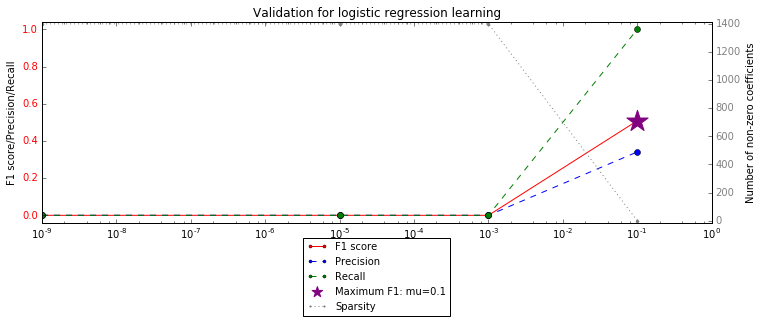

CPU times: user 10.4 s, sys: 668 ms, total: 11 s
Wall time: 10.5 s


<table><tr><td><b>ID</b></td><td><b># LFs</b></td><td><b>Test set size</b></td><td><b>Model</b></td><td><b>Precision</b></td><td><b>Recall</b></td><td><b>F1</b></td></tr><tr><td>0</td><td>35</td><td>89</td><td>Logistic regression</td><td>0.292</td><td>1.000</td><td>0.452</td></tr></table><table><tr><td><b>LF</b></td></tr><tr><td>LF_investigate</td></tr><tr><td>LF_key</td></tr><tr><td>LF_distance</td></tr><tr><td>LF_keyword</td></tr><tr><td>LF_auxpass</td></tr><tr><td>LF_inbetween</td></tr><tr><td>LF_possible</td></tr><tr><td>LF_explore</td></tr><tr><td>LF_key</td></tr><tr><td>LF_investigate</td></tr><tr><td>LF_yetToBeConfirmed</td></tr><tr><td>LF_notAssociated</td></tr><tr><td>LF_notRelated</td></tr><tr><td>LF_doesNotShow</td></tr><tr><td>LF_notLinked</td></tr><tr><td>LF_notCorrelated</td></tr><tr><td>LF_disprove</td></tr><tr><td>LF_doesNotSignify</td></tr><tr><td>LF_doesNotIndicate</td></tr><tr><td>LF_doesNotImply</td></tr><tr><td>LF_studies</td></tr><tr><td>LF_studies2</td></tr><tr><td>LF_studies3</td></tr><tr><td>LF_studies4</td></tr><tr><td>LF_interesting</td></tr><tr><td>LF_discussion</td></tr><tr><td>LF_conclusion</td></tr><tr><td>LF_recently</td></tr><tr><td>LF_induced</td></tr><tr><td>LF_treatment</td></tr><tr><td>LF_isaBiomarker</td></tr><tr><td>LF_marker</td></tr><tr><td>LF_suspect</td></tr><tr><td>LF_mark</td></tr><tr><td>LF_People</td></tr></table>

In [5]:
matplotlib.rcParams['figure.figsize'] = (12,4)
mu_seq = np.ravel([1e-9, 1e-5, 1e-3, 1e-1])
lf_opts = {'sample': False, 'verbose': True}
model_opts = {'sample': False, 'n_iter': 3000, 'alpha': 0.5, 'mu': mu_seq, 'bias': False, 'verbose': True}
%time DDL.train_model(method='lr', lf_opts=lf_opts, model_opts=model_opts)

We can use [DeepDive-style calibration plots](http://deepdive.stanford.edu/calibration) to evaluate the quality of our predictions.

/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


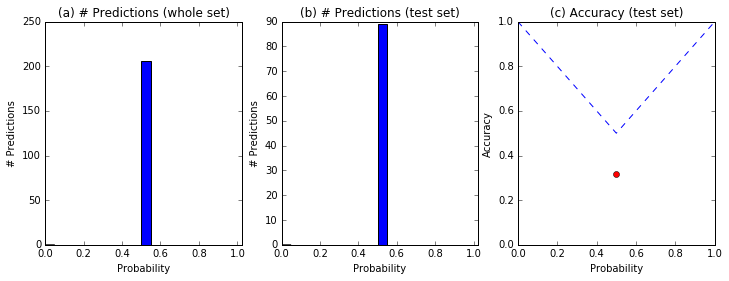

In [6]:
DDL.plot_calibration()

Since we used pipeline learning, we can also see the gain in accuracy we got from using features and not just LFs as a collection of rules.

In [22]:
idxs, gt = DDL.get_labeled_ground_truth(subset=DDL.holdout())
acc_feats = np.mean(DDL.get_predicted(subset=DDL.holdout()) == gt)

acc_lfs = np.mean(DDL.get_lf_predicted(subset=DDL.holdout()) == gt)
print "LF accuracy: {:.3f}\nFull model accuracy: {:.3f}".format(acc_lfs, acc_feats)

0.0
LF accuracy: 0.661
Full model accuracy: 0.000


## Iterating with labeling functions
After analyzing our LFs and obtaining model results, we can revise our LF set. We can see all of the results thus far, and reopen MindTagger to see some mentions that aren't currently covered by LFs.

In [8]:
DDL.show_log()

ID,# LFs,Test set size,Model,Precision,Recall,F1
0,35,89,Logistic regression,0.292,1.000,0.452


In [9]:
DDL.open_mindtagger(width='100%', height=1200, abstain=True)

Making sure MindTagger is installed. Hang on!


OSError: Mindtagger task data could not be prepared: (<type 'exceptions.StopIteration'>, StopIteration(), <traceback object at 0x7fc028961e18>)